Loading Data...
Reshaping Data...
Total Timestamps: 17925
Starting Simulation with Active Coin Filter & Metrics...
Processed: 2018-03-25 | IC: nan | RMSE: 0.0000
Processed: 2018-04-24 | IC: nan | RMSE: 0.0000
Processed: 2018-05-24 | IC: nan | RMSE: 0.0000
Processed: 2018-06-23 | IC: nan | RMSE: 0.0000
Processed: 2018-07-23 | IC: nan | RMSE: 0.0000
Processed: 2018-08-23 | IC: nan | RMSE: 0.0000
Processed: 2018-09-22 | IC: nan | RMSE: 0.0000
Processed: 2018-10-22 | IC: nan | RMSE: 0.0000
Processed: 2018-11-21 | IC: nan | RMSE: 0.0000
Processed: 2018-12-21 | IC: nan | RMSE: 0.0000
Processed: 2019-01-20 | IC: nan | RMSE: 0.0000
Processed: 2019-02-19 | IC: nan | RMSE: 0.0000
Processed: 2019-03-21 | IC: nan | RMSE: 0.0000
Processed: 2019-04-20 | IC: nan | RMSE: 0.0000
Processed: 2019-05-20 | IC: nan | RMSE: 0.0000
Processed: 2019-06-19 | IC: nan | RMSE: 0.0000
Processed: 2019-07-19 | IC: nan | RMSE: 0.0000
Processed: 2019-08-18 | IC: nan | RMSE: 0.0000
Processed: 2019-09-17 | IC: nan | RMSE:

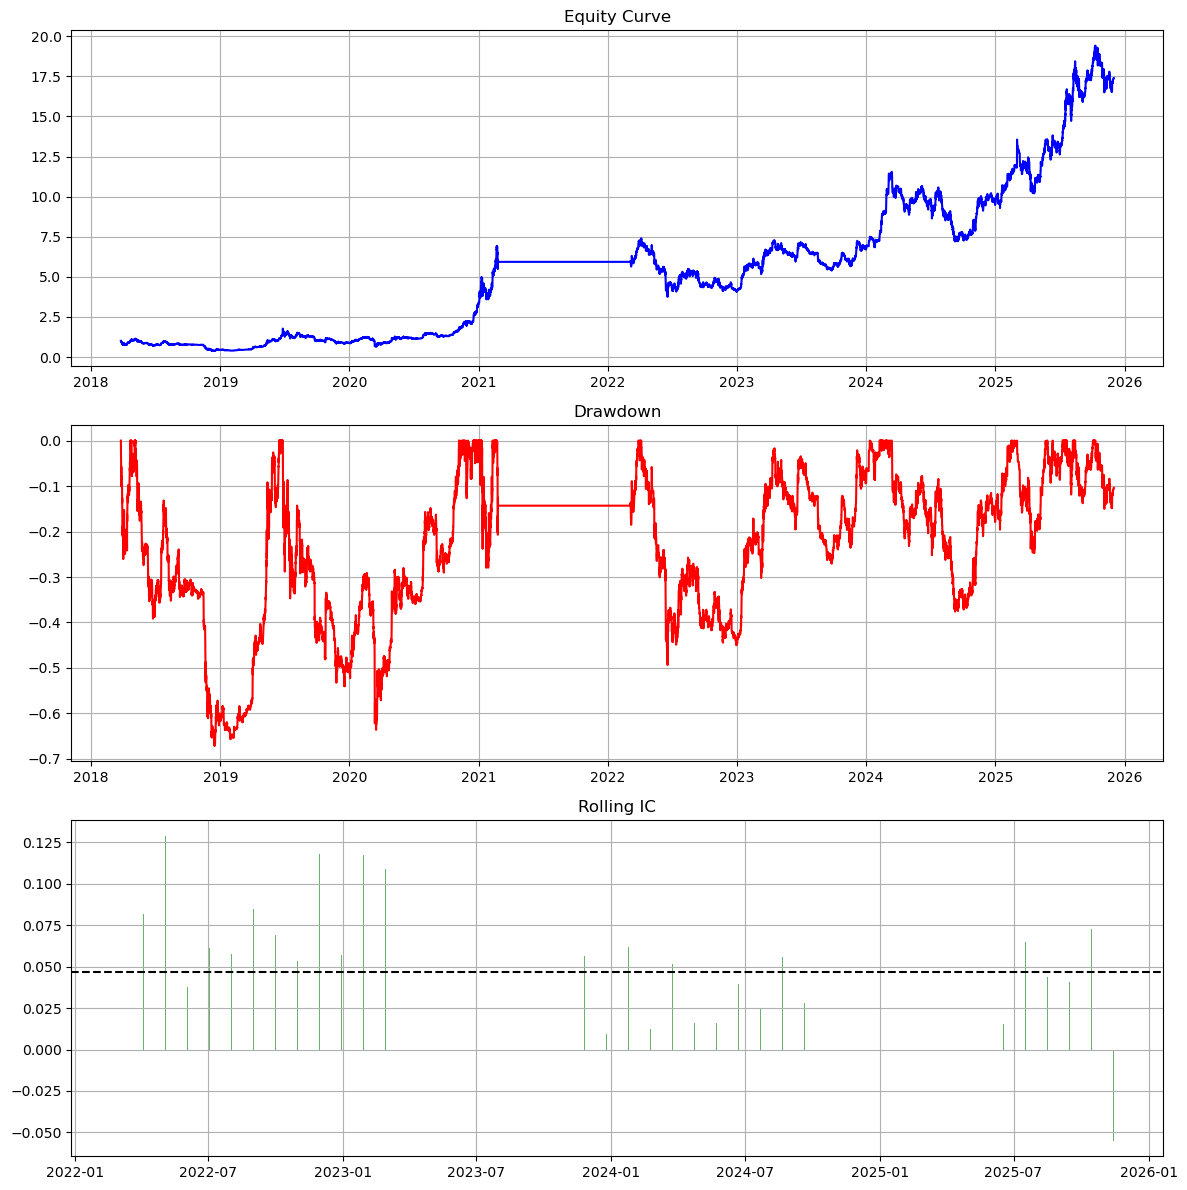

In [13]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# =============================================================================
# 1. 데이터 로드 및 병합
# =============================================================================
print("Loading Data...")
raw_path = "eth_4hour_raw_price.csv"
feat_path = "eth_4hour_master.csv"

# Raw Price & Feature 로드
df_raw = pd.read_csv(raw_path)
if "date" in df_raw.columns: df_raw = df_raw.rename(columns={"date": "timestamp"})
df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"])

df_feat = pd.read_csv(feat_path)
if "date" in df_feat.columns: df_feat = df_feat.rename(columns={"date": "timestamp"})
df_feat["timestamp"] = pd.to_datetime(df_feat["timestamp"])

# 병합
df_wide = df_raw.merge(df_feat, on="timestamp", how="inner")
df_wide = df_wide.sort_values("timestamp").reset_index(drop=True)

# =============================================================================
# 2. Wide -> Long 변환 (정확한 매핑)
# =============================================================================
coins = ["BTC", "ETH", "XRP", "SOL", "ADA", "DOGE", "AVAX", "DOT"]

def wide_to_long_fast(df_wide, coins):
    coin_prefixes = [f"{c}_" for c in coins]
    all_cols = df_wide.columns.tolist()
    global_cols = [c for c in all_cols if c != "timestamp" and not any(c.startswith(p) for p in coin_prefixes)]
    
    frames = []
    for c in coins:
        coin_cols = [col for col in all_cols if col.startswith(f"{c}_")]
        sub = df_wide[["timestamp"] + global_cols + coin_cols].copy()
        
        rename_map = {}
        for col in coin_cols:
            new_name = col.replace(f"{c}_", "")
            if new_name == "Close": rename_map[col] = "close_krw"
            elif new_name == "Open": rename_map[col] = "open_krw"
            elif new_name == "High": rename_map[col] = "high_krw"
            elif new_name == "Low": rename_map[col] = "low_krw"
            elif new_name == "Volume": rename_map[col] = "volume_krw"
            elif new_name == "Bin_Close": rename_map[col] = "close_usd"
            else: rename_map[col] = new_name
            
        sub = sub.rename(columns=rename_map)
        sub["asset_id"] = c
        frames.append(sub)
    return pd.concat(frames, ignore_index=True)

print("Reshaping Data...")
df = wide_to_long_fast(df_wide, coins)
df = df.sort_values(["timestamp", "asset_id"]).reset_index(drop=True)

# =============================================================================
# 3. 타겟 생성 & 학습 데이터 준비
# =============================================================================
g_price = df.groupby("asset_id")["close_krw"]
df["close_krw_next"] = g_price.shift(-1)
df["log_ret_1"] = np.log(df["close_krw_next"] / (df["close_krw"] + 1e-9))

# Alpha Target (Market Neutral)
df["market_ret_1"] = df.groupby("timestamp")["log_ret_1"].transform("mean")
df["resid_ret_1"] = df["log_ret_1"] - df["market_ret_1"]
g_ret = df.groupby("asset_id")["log_ret_1"]
df["vol_30"] = g_ret.rolling(window=30, min_periods=20).std().reset_index(level=0, drop=True)
df["raw_target"] = df["resid_ret_1"] / (df["vol_30"] + 1e-9)
df["target"] = df.groupby("timestamp")["raw_target"].transform(lambda x: x.rank(pct=True, method="first") - 0.5)

# 결측치 처리
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
le = LabelEncoder()
df["asset_id_enc"] = le.fit_transform(df["asset_id"])

# Feature Selection (Target Leakage 방지)
exclude_cols = ["timestamp", "asset_id", "target", "close_krw_next", "log_ret_1", 
                "market_ret_1", "resid_ret_1", "raw_target", "open_krw", "high_krw", 
                "low_krw", "close_krw", "volume_krw", "close_usd"]
features = [c for c in df.columns if c not in exclude_cols]

# =============================================================================
# 4. Walk-Forward Simulation (Metrics + Active Filter + Smart Logic)
# =============================================================================
TRAIN_WINDOW = 30 * 6 * 6 # 6개월
TEST_WINDOW = 30 * 6      # 1개월

timestamps = np.sort(df["timestamp"].unique())
n_timestamps = len(timestamps)

print(f"Total Timestamps: {n_timestamps}")
print("Starting Simulation with Active Coin Filter & Metrics...")

simulation_results = []
metrics_log = []
current_idx = TRAIN_WINDOW

# BTC Global Info Map (속도 최적화)
btc_info = df_wide.set_index("timestamp")
# 컬럼명이 파일에 따라 다를 수 있으니 확인 후 매핑 (없으면 기본값 0)
# 사용자님 파일의 정확한 컬럼명을 사용해야 함. 여기선 표준 이름을 가정.
btc_map_squeeze = btc_info.get("BTC_is_squeeze", pd.Series(0, index=btc_info.index)).to_dict()
btc_map_obv = btc_info.get("BTC_OBV_Trend", pd.Series(1, index=btc_info.index)).to_dict() # 기본값 1(상승)로 둬서 뚫어줌
btc_map_spike = btc_info.get("BTC_Vol_Spike", pd.Series(0, index=btc_info.index)).to_dict()
btc_map_climax = btc_info.get("BTC_Buying_Climax", pd.Series(0, index=btc_info.index)).to_dict()
btc_map_kp = btc_info.get("BTC_KP_Ratio", pd.Series(1, index=btc_info.index)).to_dict()

while current_idx < n_timestamps:
    train_start = timestamps[current_idx - TRAIN_WINDOW]
    test_start = timestamps[current_idx]
    next_idx = min(current_idx + TEST_WINDOW, n_timestamps)
    test_end = timestamps[next_idx - 1]
    
    train_mask = (df["timestamp"] >= train_start) & (df["timestamp"] < test_start)
    test_mask = (df["timestamp"] >= test_start) & (df["timestamp"] <= test_end)
    
    if not test_mask.any(): break
    
    # [Active Coin Filter] 상장 전(0값) 데이터 제거
    # 학습할 때도 0값은 제외해야 모델이 헷갈리지 않음
    real_train_idx = df.loc[train_mask][(df.loc[train_mask, "close_krw"] > 0) & (df.loc[train_mask, "volume_krw"] > 0)].index
    
    if len(real_train_idx) < 100:
        current_idx = next_idx
        continue
        
    # Train
    X_train = df.loc[real_train_idx, features]
    y_train = df.loc[real_train_idx, "target"]
    
    lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
    lgb_model.fit(X_train, y_train)
    
    # Predict (Active Coins Only)
    # 테스트 때도 살아있는 코인만 예측
    real_test_idx = df.loc[test_mask][(df.loc[test_mask, "close_krw"] > 0) & (df.loc[test_mask, "volume_krw"] > 0)].index
    
    if len(real_test_idx) == 0:
        current_idx = next_idx
        continue
        
    df_test = df.loc[real_test_idx].copy()
    df_test["pred"] = lgb_model.predict(df_test[features])
    
    # [Metrics Calculation] RMSE & IC
    rmse = np.sqrt(mean_squared_error(df_test["target"], df_test["pred"]))
    ic = df_test.groupby("timestamp").apply(
        lambda x: x["pred"].corr(x["target"], method="spearman") if len(x) > 1 else np.nan
    ).mean()
    
    metrics_log.append({"period": pd.Timestamp(test_start).date(), "ic": ic, "rmse": rmse})
    print(f"Processed: {pd.Timestamp(test_start).date()} | IC: {ic:.4f} | RMSE: {rmse:.4f}")
    
    # Rank Calculation (살아있는 애들끼리만 경쟁)
    df_test["rank"] = df_test.groupby("timestamp")["pred"].rank(ascending=False)
    
    # --- Simulation ---
    for ts, group in df_test.groupby("timestamp"):
        # Context 조회
        is_squeeze = btc_map_squeeze.get(ts, 0)
        obv_trend = btc_map_obv.get(ts, 1)
        vol_spike = btc_map_spike.get(ts, 0)
        buy_climax = btc_map_climax.get(ts, 0)
        kp = btc_map_kp.get(ts, 1.0)
        
        action = "HOLD"
        ret = 0.0
        
        # 1. Defensive Filter
        if obv_trend == -1: # 수급 이탈 시 절대 방어
            simulation_results.append({"timestamp": ts, "return": 0.0, "action": "HOLD_BEAR"})
            continue
            
        if is_squeeze == 1: # 횡보장
            simulation_results.append({"timestamp": ts, "return": 0.0, "action": "HOLD_SQUEEZE"})
            continue
            
        # 2. Offensive Trigger (진입 조건 완화: Trend가 1이면 일단 가능)
        # 너무 빡빡해서 거래가 안 되던 문제 해결 -> obv_trend == 1이면 기본 진입 가능
        is_signal = (vol_spike == 1) or (buy_climax == 1) or (obv_trend == 1)
        
        if is_signal:
            if kp is None: # 김프 필터
                simulation_results.append({"timestamp": ts, "return": 0.0, "action": "HOLD_KIMP"})
                continue
                
            # [BTC/ETH Priority Logic]
            # 전체 순위도 중요하지만, BTC/ETH 중 하나라도 상위권에 있어야 함
            candidates = group[group["asset_id"].isin(["BTC", "ETH"])]
            
            if not candidates.empty:
                best = candidates.sort_values("pred", ascending=False).iloc[0]
                
                # 전체 3위 이내면 강력 매수
                if best["rank"] <= 3:
                    ret = np.exp(best["log_ret_1"]) - 1.0
                    action = f"BUY_{best['asset_id']}"
                else:
                    action = "HOLD_LOW_RANK" # 순위가 낮으면 안 삼
            else:
                action = "HOLD_NO_CANDIDATE" # 데이터 오류 등으로 후보 없을 때
        else:
            action = "HOLD_NO_SIGNAL"
            
        simulation_results.append({"timestamp": ts, "return": ret, "action": action})
        
    current_idx = next_idx

# =============================================================================
# 5. 최종 리포트
# =============================================================================
res_df = pd.DataFrame(simulation_results)
res_df = res_df.set_index("timestamp").sort_index()
res_df["cum_return"] = (1 + res_df["return"]).cumprod()
res_df["drawdown"] = res_df["cum_return"] / res_df["cum_return"].cummax() - 1.0

total_ret = res_df["cum_return"].iloc[-1] - 1.0
mdd = res_df["drawdown"].min()
met_df = pd.DataFrame(metrics_log)

print("\n" + "="*50)
print(" [Final Strategy Report]")
print(f" Total Return : {total_ret*100:.2f}%")
print(f" Max Drawdown : {mdd*100:.2f}%")
print(f" Avg IC       : {met_df['ic'].mean():.4f}")
print(f" Avg RMSE     : {met_df['rmse'].mean():.4f}")
print("="*50)

print("\nTop Actions:")
print(res_df["action"].value_counts().head(10))

# 시각화
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
ax[0].plot(res_df.index, res_df["cum_return"], label="Equity", color="blue")
ax[0].set_title("Equity Curve")
ax[0].grid(True)

ax[1].plot(res_df.index, res_df["drawdown"], label="Drawdown", color="red")
ax[1].set_title("Drawdown")
ax[1].grid(True)

ax[2].bar(met_df["period"], met_df["ic"], color="green", alpha=0.6)
ax[2].axhline(y=met_df['ic'].mean(), color="black", linestyle="--")
ax[2].set_title("Rolling IC")
ax[2].grid(True)

plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. 데이터 로드 및 핵심 지표 선별
# =============================================================================
print("Loading Data...")
raw_path = "eth_4hour_raw_price.csv"
feat_path = "eth_4hour_master.csv"

df_raw = pd.read_csv(raw_path)
df_raw["date"] = pd.to_datetime(df_raw["date"])
df_feat = pd.read_csv(feat_path)
df_feat["date"] = pd.to_datetime(df_feat["date"])

# 병합
df_wide = df_raw.merge(df_feat, on="date", how="inner")
df_wide = df_wide.sort_values("date").reset_index(drop=True)

coins = ["BTC", "ETH", "XRP", "SOL", "ADA", "DOGE", "AVAX", "DOT"]

def wide_to_long_strategic(df_wide, coins):
    frames = []
    
    # [핵심 전략] 모델이 집중해야 할 지표 키워드 (사용자 코드 기반)
    # 이 키워드가 포함된 컬럼만 가져옵니다. (잡동사니 제거)
    strategic_keywords = [
        "Close", "Open", "High", "Low", "Volume", # 기본 가격
        "Vol_Spike", "Buying_Climax", "Absorption", "OBV_Trend", "CVD_Slope", # 세력/수급
        "TREND_SCORE", "ADX_14", "Fast_Pct", "Dist_from_VWAP", # 추세/모멘텀
        "is_squeeze", "high_volatility_regime", "BB_WIDTH", "ATR_84", # 변동성
        "KP_Ratio" # 김프
    ]
    
    # 글로벌(매크로) 지표는 다 가져감
    coin_prefixes = [f"{c}_" for c in coins]
    global_cols = [c for c in df_wide.columns if c != "date" and not any(c.startswith(p) for p in coin_prefixes)]
    
    for c in coins:
        # 해당 코인의 지표 중 '전략 키워드'가 포함된 것만 선별
        coin_cols = [col for col in df_wide.columns if col.startswith(f"{c}_") and any(k in col for k in strategic_keywords)]
        
        sub = df_wide[["date"] + global_cols + coin_cols].copy()
        rename_map = {}
        for col in coin_cols:
            suffix = col.replace(f"{c}_", "")
            # 기본 가격 매핑
            if suffix == "Close": rename_map[col] = "close_krw"
            elif suffix == "Open": rename_map[col] = "open_krw"
            elif suffix == "High": rename_map[col] = "high_krw"
            elif suffix == "Low": rename_map[col] = "low_krw"
            elif suffix == "Volume": rename_map[col] = "volume_krw"
            elif suffix == "Bin_Close": rename_map[col] = "close_usd"
            else: rename_map[col] = suffix # 나머지는 접두사 뗀 이름으로
            
        sub = sub.rename(columns=rename_map)
        sub["asset_id"] = c
        frames.append(sub)
    return pd.concat(frames, ignore_index=True)

print("Reshaping & Selecting Strategic Features...")
df = wide_to_long_strategic(df_wide, coins)
df = df.rename(columns={"date": "timestamp"})
df = df.sort_values(["timestamp", "asset_id"]).reset_index(drop=True)

# [정밀 필터] 상장 초기 불안정 데이터 제거 (가격 발생 후 100캔들 스킵)
valid_indices = []
for asset in coins:
    asset_df = df[df["asset_id"] == asset]
    first_valid = asset_df[asset_df["close_krw"] > 0].index.min()
    if pd.notna(first_valid):
        # 100캔들 이후 & 거래대금 10억 이상 (잡음 제거)
        mask = (asset_df.index >= first_valid + 100) & ((asset_df["close_krw"] * asset_df["volume_krw"]) > 1_000_000_000)
        valid_indices.extend(asset_df[mask].index.tolist())
df = df.loc[valid_indices].sort_values(["timestamp", "asset_id"]).reset_index(drop=True)

# =============================================================================
# 2. [Target] Dynamic Breakout (ATR * 2 돌파)
# =============================================================================
print("Generating Dynamic Target...")
# ATR이 없으면 직접 계산
if "ATR_84" not in df.columns:
    df["tr"] = np.maximum(df["high_krw"] - df["low_krw"], (df["high_krw"] - df["close_krw"].shift(1)).abs())
    df["ATR_84"] = df.groupby("asset_id")["tr"].rolling(84).mean().reset_index(level=0, drop=True)

# 목표: 현재가 + ATR * 2.0
df["dynamic_threshold"] = df["close_krw"] + (df["ATR_84"] * 2.0)

# 미래 24시간(6캔들) 최고가 확인
g_high = df.groupby("asset_id")["high_krw"]
future_high = g_high.shift(-1)
for i in range(2, 7):
    future_high = np.maximum(future_high, g_high.shift(-i))

df["is_breakout"] = (future_high >= df["dynamic_threshold"]).astype(int)
df = df.dropna(subset=["is_breakout", "ATR_84"]).fillna(0)

le = LabelEncoder()
df["asset_id_enc"] = le.fit_transform(df["asset_id"])
print(f"Target Ratio: {df['is_breakout'].mean():.4f}")

# =============================================================================
# 3. Walk-Forward (Precision Focused)
# =============================================================================
exclude_cols = ["timestamp", "asset_id", "is_breakout", "high_krw", "low_krw", "open_krw", 
                "close_krw", "volume_krw", "close_usd", "tr", "dynamic_threshold", "ATR_84"]
candidate_features = [c for c in df.columns if c not in exclude_cols]

TRAIN_WINDOW = 30 * 6 * 12 # 1년
TEST_WINDOW = 30 * 6       # 1개월
timestamps = np.sort(df["timestamp"].unique())
n_timestamps = len(timestamps)

print(f"Starting Strategic Walk-Forward...")

results = []
all_signals = []
current_idx = TRAIN_WINDOW

while current_idx < n_timestamps:
    train_start = timestamps[current_idx - TRAIN_WINDOW]
    test_start = timestamps[current_idx]
    next_idx = min(current_idx + TEST_WINDOW, n_timestamps)
    
    train_mask = (df["timestamp"] >= train_start) & (df["timestamp"] < test_start)
    test_mask = (df["timestamp"] >= test_start) & (df["timestamp"] <= timestamps[next_idx - 1])
    
    if not test_mask.any(): break
    
    X_train = df.loc[train_mask, candidate_features]
    y_train = df.loc[train_mask, "is_breakout"]
    
    if y_train.sum() < 50:
        current_idx = next_idx
        continue
        
    # Training
    model = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.02, num_leaves=31, 
                               is_unbalance=True, random_state=42, n_jobs=-1, verbose=-1)
    model.fit(X_train, y_train)
    
    # Prediction
    test_active = df.loc[test_mask].copy()
    if len(test_active) == 0:
        current_idx = next_idx
        continue
        
    preds_proba = model.predict_proba(test_active[candidate_features])[:, 1]
    test_active["prob"] = preds_proba
    
    # Signal Export
    signals = test_active[["timestamp", "asset_id", "close_krw", "prob", "is_breakout"]].copy()
    
    # [Strict Filter] 확률 0.65 이상만 저장 (확실한 것만)
    buy_candidates = signals[signals["prob"] >= 0.65]
    all_signals.append(buy_candidates)
    
    # Metrics
    try: auc = roc_auc_score(test_active["is_breakout"], preds_proba)
    except: auc = 0.5
    
    print(f"Processed: {pd.Timestamp(test_start).date()} | AUC: {auc:.4f}")
    current_idx = next_idx

if all_signals:
    final_signals = pd.concat(all_signals, ignore_index=True)
    final_signals.to_csv("trade_signals_strategic.csv", index=False)
    print("\n✅ 'trade_signals_strategic.csv' Saved!")



Loading Data...
Reshaping & Selecting Strategic Features...
Generating Dynamic Target...
Target Ratio: 0.2116
Starting Strategic Walk-Forward...
Processed: 2018-10-30 | AUC: 0.4753
Processed: 2018-11-29 | AUC: 0.7062
Processed: 2018-12-30 | AUC: 0.6285
Processed: 2019-01-29 | AUC: 0.5140
Processed: 2019-03-01 | AUC: 0.5785
Processed: 2019-03-31 | AUC: 0.6682
Processed: 2019-04-30 | AUC: 0.6169
Processed: 2019-05-30 | AUC: 0.5400
Processed: 2019-06-29 | AUC: 0.6949
Processed: 2019-07-29 | AUC: 0.6328
Processed: 2019-08-28 | AUC: 0.5561
Processed: 2019-09-27 | AUC: 0.6261
Processed: 2019-10-28 | AUC: 0.5947
Processed: 2019-11-27 | AUC: 0.5534
Processed: 2019-12-29 | AUC: 0.6007
Processed: 2020-01-29 | AUC: 0.5617
Processed: 2020-02-28 | AUC: 0.4568
Processed: 2020-03-29 | AUC: 0.5249
Processed: 2020-04-28 | AUC: 0.6298
Processed: 2020-05-28 | AUC: 0.6336
Processed: 2020-06-28 | AUC: 0.4591
Processed: 2020-07-29 | AUC: 0.6716
Processed: 2020-08-28 | AUC: 0.4662
Processed: 2020-09-27 | AUC

Loading Data for ETH Strategy...
Total ETH Data Points: 523
Running Adaptive Strategy (More Trades)...

 [Professional Strategy Report]
 Strategy Return : 3081.06%
 Benchmark Return: 1296.59% (ETH Buy&Hold)
 Strategy MDD    : -18.11%
 Benchmark MDD   : -74.99%
 Sharpe Ratio    : 1.33

 Total Trades    : 127
 Win Rate        : 60.63%
 Avg Profit      : 10.91%
 Avg Loss        : -3.90%


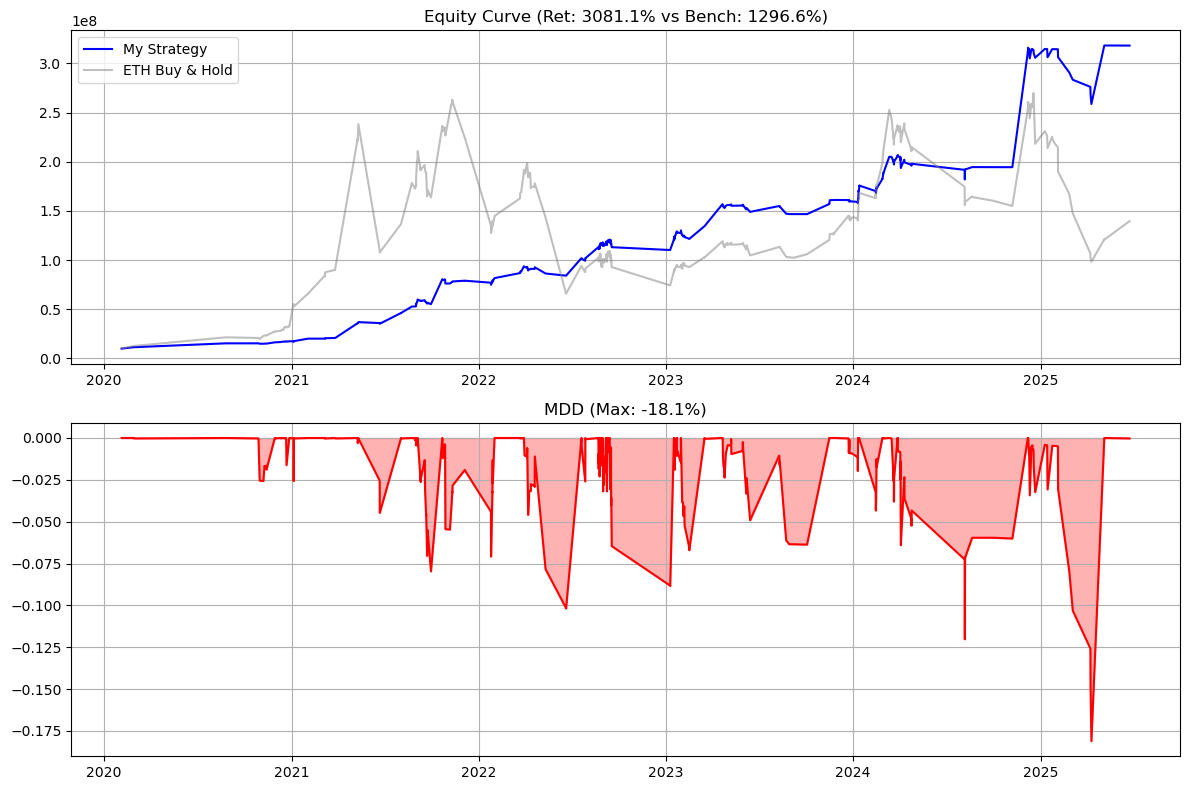

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. 데이터 로드 및 컬럼명 안전 통일
# =============================================================================
print("Loading Data for ETH Strategy...")

# 1) 매매 신호
signals = pd.read_csv("trade_signals_strategic.csv")
signals["timestamp"] = pd.to_datetime(signals["timestamp"])

# 2) 기술적 지표 데이터 (ETH 필터용)
market_data = pd.read_csv("eth_4hour_master.csv")
if "date" in market_data.columns:
    market_data = market_data.rename(columns={"date": "timestamp"})
market_data["timestamp"] = pd.to_datetime(market_data["timestamp"])

# 3) 가격 데이터 (수익률 계산용)
price_data = pd.read_csv("eth_4hour_raw_price.csv")
if "date" in price_data.columns:
    price_data = price_data.rename(columns={"date": "timestamp"})
price_data["timestamp"] = pd.to_datetime(price_data["timestamp"])

# 데이터 병합
full_data = signals.merge(market_data, on="timestamp", how="inner")
full_data = full_data.merge(price_data, on="timestamp", how="inner")

# ETH만 남기고 2024년 이후 데이터 필터링
eth_data = full_data[full_data["asset_id"] == "ETH"].sort_values("timestamp").reset_index(drop=True)
eth_data = eth_data[eth_data['timestamp'] >= '2020-01-01'].copy()

# [핵심 수정] 컬럼 이름 강제 매핑 (에러 방지)
# 데이터에 'ETH_High'가 있으면 'high_krw'로 복사, 없으면 기존 'high_krw' 사용
if "ETH_High" in eth_data.columns: eth_data["high_krw"] = eth_data["ETH_High"]
if "ETH_Low" in eth_data.columns: eth_data["low_krw"] = eth_data["ETH_Low"]
if "ETH_Close" in eth_data.columns: eth_data["close_krw"] = eth_data["ETH_Close"]
if "ETH_Open" in eth_data.columns: eth_data["open_krw"] = eth_data["ETH_Open"]

# ADX 컬럼도 확실하게 처리 (없으면 기본값 25 처리해서 에러 방지)
if "ETH_ADX_14" not in eth_data.columns:
    print("⚠️ ADX Column not found. Creating dummy ADX=25 (Pass filter)")
    eth_data["ETH_ADX_14"] = 25

print(f"Total ETH Data Points: {len(eth_data)}")

# =============================================================================
# 2. [Adaptive Strategy] 유연한 진입 & 동적 베팅
# =============================================================================
initial_balance = 10_000_000
balance = initial_balance
balance_history = []
trade_log = []

# 벤치마크(Buy & Hold)용
eth_hold_amt = initial_balance / eth_data.iloc[0]["close_krw"]

# 파라미터
STOP_LOSS = -0.05
TAKE_PROFIT = 0.09
TRAILING_START = 0.04
TRAILING_CALLBACK = 0.02

print("Running Adaptive Strategy (More Trades)...")

position = False
entry_price = 0
max_price = 0
entry_ts = None
bet_ratio = 0.0 

for i in range(len(eth_data) - 1):
    row = eth_data.iloc[i]
    next_row = eth_data.iloc[i+1]
    ts = row["timestamp"]
    current_price = row["close_krw"]
    
    # --- [매수 진입] ---
    if not position:
        prob = row["prob"]
        adx = row.get("ETH_ADX_14", 25)
        
        # [수정] 진입 로직 유연화
        # Case A: 확신이 매우 높으면(>0.8), ADX 무시하고 풀베팅
        if prob >= 0.75:
            bet_ratio = 1.0
        # Case B: 확신이 적당하면(>0.7), ADX 20 이상일 때만 절반 베팅
        elif prob >= 0.65 and adx >= 20:
            bet_ratio = 0.5
        # Case C: 확신이 약하면(>0.6), ADX 25 이상(강한 추세)일 때만 소액(30%) 베팅
        elif prob >= 0.6 and adx >= 25:
            bet_ratio = 0.3
        else:
            # 벤치마크 가치 계산
            bench_val = eth_hold_amt * current_price
            balance_history.append({"ts": ts, "bal": balance, "bench": bench_val})
            continue
            
        # 기술적 필터 (최소한의 안전장치)
        if row.get("ETH_RSI_84", 50) > 75: continue # 과열만 피하자

        # 진입
        position = True
        entry_price = current_price
        max_price = current_price
        entry_ts = ts
        
        fee = (balance * bet_ratio) * 0.0005 
        balance -= fee 
        
        trade_log.append({"type": "BUY", "ts": ts, "price": entry_price, "prob": prob, "size": bet_ratio})
        
        bench_val = eth_hold_amt * current_price
        balance_history.append({"ts": ts, "bal": balance, "bench": bench_val})
        
    # --- [청산] ---
    else:
        high_price = next_row["high_krw"]
        low_price = next_row["low_krw"]
        
        invested_amt = balance * bet_ratio
        cash_amt = balance * (1 - bet_ratio)
        
        max_price = max(max_price, high_price)
        max_ret = (max_price / entry_price) - 1
        
        # 1. Trailing Stop
        if max_ret >= TRAILING_START:
            stop_price = max_price * (1 - TRAILING_CALLBACK)
            if low_price <= stop_price:
                sell_price = stop_price
                ret = (sell_price / entry_price) - 1
                balance = cash_amt + (invested_amt * (1 + ret) * 0.9995)
                position = False
                trade_log.append({"type": "SELL_TRAIL", "ts": next_row["timestamp"], "ret": ret})
                
                bench_val = eth_hold_amt * next_row["close_krw"]
                balance_history.append({"ts": next_row["timestamp"], "bal": balance, "bench": bench_val})
                continue
                
        # 2. Stop Loss
        if low_price <= entry_price * (1 + STOP_LOSS):
            ret = STOP_LOSS
            balance = cash_amt + (invested_amt * (1 + ret) * 0.9995)
            position = False
            trade_log.append({"type": "SELL_SL", "ts": next_row["timestamp"], "ret": ret})
            
            bench_val = eth_hold_amt * next_row["close_krw"]
            balance_history.append({"ts": next_row["timestamp"], "bal": balance, "bench": bench_val})
            continue
            
        # 3. Time Exit (유연하게 48시간으로 연장)
        if (ts - entry_ts).total_seconds() >= 3600 * 48:
            ret = (current_price / entry_price) - 1
            balance = cash_amt + (invested_amt * (1 + ret) * 0.9995)
            position = False
            trade_log.append({"type": "SELL_TIME", "ts": ts, "ret": ret})
            
            bench_val = eth_hold_amt * current_price
            balance_history.append({"ts": ts, "bal": balance, "bench": bench_val})
            continue
            
        # Holding
        curr_ret = (current_price / entry_price) - 1
        curr_val = cash_amt + (invested_amt * (1 + curr_ret))
        bench_val = eth_hold_amt * current_price
        balance_history.append({"ts": ts, "bal": curr_val, "bench": bench_val})

# =============================================================================
# 3. Professional Report (MDD, Sharpe)
# =============================================================================
res_df = pd.DataFrame(balance_history).set_index("ts")
tr_df = pd.DataFrame(trade_log)

# MDD 계산
res_df["peak"] = res_df["bal"].cummax()
res_df["dd"] = (res_df["bal"] - res_df["peak"]) / res_df["peak"]
mdd = res_df["dd"].min()

# Benchmark MDD
res_df["bench_peak"] = res_df["bench"].cummax()
res_df["bench_dd"] = (res_df["bench"] - res_df["bench_peak"]) / res_df["bench_peak"]
bench_mdd = res_df["bench_dd"].min()

# Sharpe Ratio (일간 수익률 기준, 무위험이자율 3%)
daily_df = res_df["bal"].resample("D").last().pct_change().dropna()
sharpe = (daily_df.mean() * 365 - 0.03) / (daily_df.std() * np.sqrt(365))

final_ret = (balance / initial_balance) - 1
bench_ret = (res_df["bench"].iloc[-1] / initial_balance) - 1

print("\n" + "="*50)
print(f" [Professional Strategy Report]")
print(f" Strategy Return : {final_ret*100:.2f}%")
print(f" Benchmark Return: {bench_ret*100:.2f}% (ETH Buy&Hold)")
print(f" Strategy MDD    : {mdd*100:.2f}%")
print(f" Benchmark MDD   : {bench_mdd*100:.2f}%")
print(f" Sharpe Ratio    : {sharpe:.2f}")

if not tr_df.empty:
    sell_trades = tr_df[tr_df['type'].str.contains('SELL')]
    print(f"\n Total Trades    : {len(sell_trades)}")
    if len(sell_trades) > 0:
        win_rate = (sell_trades['ret'] > 0).mean()
        avg_profit = sell_trades[sell_trades['ret'] > 0]['ret'].mean()
        avg_loss = sell_trades[sell_trades['ret'] < 0]['ret'].mean()
        print(f" Win Rate        : {win_rate*100:.2f}%")
        print(f" Avg Profit      : {avg_profit*100:.2f}%")
        print(f" Avg Loss        : {avg_loss*100:.2f}%")
print("="*50)

# 그래프
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(res_df.index, res_df["bal"], label="My Strategy", color='blue')
plt.plot(res_df.index, res_df["bench"], label="ETH Buy & Hold", color='gray', alpha=0.5)
plt.title(f"Equity Curve (Ret: {final_ret*100:.1f}% vs Bench: {bench_ret*100:.1f}%)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(res_df.index, res_df["dd"], label="Drawdown", color='red')
plt.fill_between(res_df.index, res_df["dd"], 0, color='red', alpha=0.3)
plt.title(f"MDD (Max: {mdd*100:.1f}%)")
plt.grid()
plt.tight_layout()
plt.show()


Loading Data & Preparing Strategy...
✅ Data Ready: 4133 candles (2024~)
🚀 Running Strategy: Trend Following + Fast Pullback...

 [Strategy Result]
 Final Equity : 9,308,543 KRW
 Total Return : -6.91%
 Benchmark    : 16.01%
 MDD          : -9.52%
 Total Trades : 21 (Buy)
 Win Rate     : 42.86% (9/21)
 Avg Profit   : 2.87%
 Avg Loss     : -3.78%


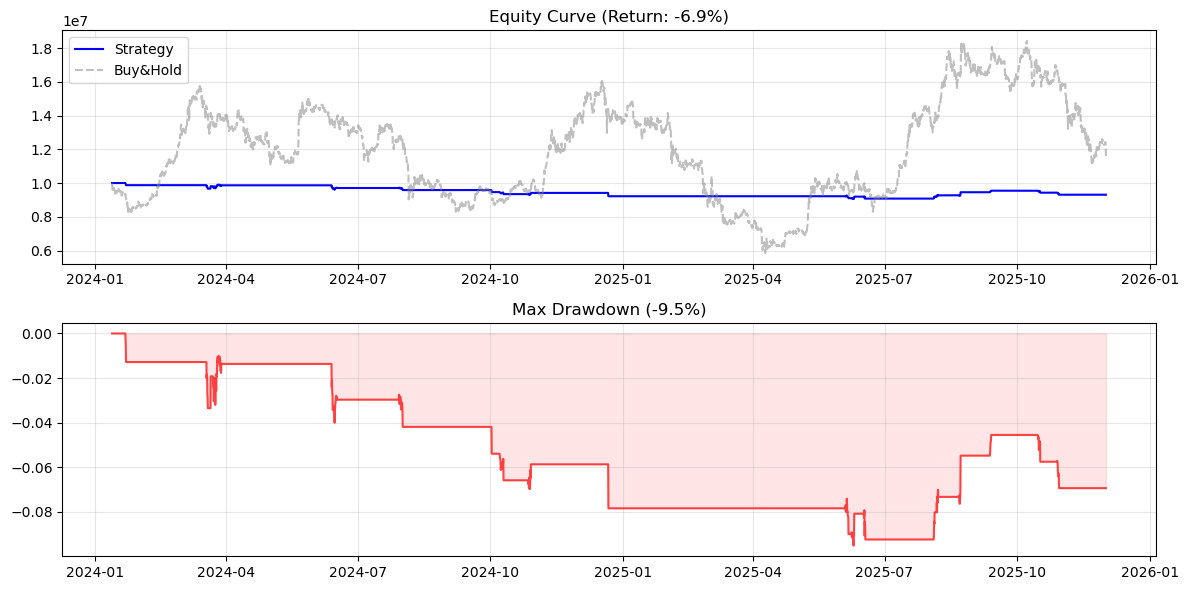

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

# =============================================================================
# 1. 데이터 로드 및 필수 지표 재확인
# =============================================================================
print("Loading Data & Preparing Strategy...")

try:
    # 1. 데이터 파일 로드
    df = pd.read_csv("eth_4hour_master.csv")
    price_df = pd.read_csv("eth_4hour_raw_price.csv")
    
    # 2. 날짜 컬럼 통일 (timestamp)
    if "date" in df.columns: df = df.rename(columns={"date": "timestamp"})
    if "date" in price_df.columns: price_df = price_df.rename(columns={"date": "timestamp"})
    
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    price_df["timestamp"] = pd.to_datetime(price_df["timestamp"])
    
    # 3. 데이터 병합 (지표 데이터 + 원본 가격 데이터)
    df = df.merge(price_df, on="timestamp", how="inner")
    df = df.sort_values("timestamp").reset_index(drop=True)
    
    # 4. 2024년 이후 데이터 필터링 (최신 트렌드 반영)
    df = df[df['timestamp'] >= '2024-01-01'].copy().reset_index(drop=True)

    # 5. 컬럼명 매핑 (코드 내 통일된 변수명 사용을 위해)
    col_map = {
        "ETH_Open": "open_krw", "ETH_High": "high_krw", 
        "ETH_Low": "low_krw", "ETH_Close": "close_krw",
        "open": "open_krw", "high": "high_krw", 
        "low": "low_krw", "close": "close_krw"
    }
    df = df.rename(columns=col_map)
    
    # -------------------------------------------------------------------------
    # [핵심 수정] 지표 안전 계산 로직 (에러 방지)
    # -------------------------------------------------------------------------
    
    # (1) 장기 추세 (SMA 200)
    if "ETH_REGIME_SMA200" not in df.columns:
        df["sma_200"] = ta.sma(df["close_krw"], length=200)
        # NaN 값 처리 (초반 데이터)
        df["ETH_REGIME_SMA200"] = (df["close_krw"] > df["sma_200"]).fillna(False).astype(int)
        
    # (2) 눌림목 확인용 (EMA 72 이격도)
    if "ETH_Dist_EMA_72" not in df.columns:
        df["ema_72"] = ta.ema(df["close_krw"], length=72)
        df["ETH_Dist_EMA_72"] = (df["close_krw"] / df["ema_72"]) - 1
        
    # (3) 진입 트리거 (MACD Fast 12,26,9) - [여기가 에러 원인이었음]
    if "ETH_MACD_MACDh_12_26_9_Fast_Pct" not in df.columns:
        # MACD 계산
        macd = ta.macd(df["close_krw"], fast=12, slow=26, signal=9)
        
        if macd is not None and not macd.empty:
            # 컬럼명에 'h' 또는 'hist'가 들어가는 컬럼(히스토그램)을 찾음
            hist_candidates = [c for c in macd.columns if "h" in c.lower() or "hist" in c.lower()]
            
            if hist_candidates:
                hist_col = hist_candidates[0] # 찾은 첫 번째 컬럼 사용
            else:
                hist_col = macd.columns[1] # 못 찾으면 보통 두 번째 컬럼이 히스토그램임
                
            df["ETH_MACD_MACDh_12_26_9_Fast_Pct"] = (macd[hist_col] / df["close_krw"]) * 100
        else:
            # 계산 실패 시 0으로 채움
            df["ETH_MACD_MACDh_12_26_9_Fast_Pct"] = 0

    # (4) 횡보장 필터 (ADX 14)
    if "ETH_ADX_14" not in df.columns:
        adx = ta.adx(df["high_krw"], df["low_krw"], df["close_krw"], length=14)
        if adx is not None and not adx.empty:
            df["ETH_ADX_14"] = adx[adx.columns[0]] # ADX 값
        else:
            df["ETH_ADX_14"] = 25 # 기본값

    # 결측치(NaN) 제거 (지표 계산 초반 구간)
    df = df.dropna().reset_index(drop=True)
    
    print(f"✅ Data Ready: {len(df)} candles (2024~)")

except Exception as e:
    import traceback
    print(f"❌ Error Loading Data: {e}")
    print(traceback.format_exc()) # 상세 에러 출력
    df = pd.DataFrame()

# =============================================================================
# 2. 백테스팅 엔진 (슬리피지/수수료 포함)
# =============================================================================
if not df.empty:
    initial_balance = 10_000_000
    cash = initial_balance
    coin_amount = 0.0
    
    # 비용 설정
    COMMISSION = 0.0005  # 0.05%
    SLIPPAGE = 0.0010    # 0.10%
    
    # 전략 파라미터
    STOP_LOSS = -0.04       # -4% 손절
    TRAILING_START = 0.03   # +3% 수익 시 트레일링 준비
    TRAILING_CALLBACK = 0.015 # 고점 대비 1.5% 반납 시 익절
    TIME_EXIT_HOURS = 72    # 3일 보유 후 반응 없으면 청산
    
    balance_history = []
    trade_log = []
    
    is_holding = False
    entry_price = 0.0
    max_price_since_entry = 0.0
    entry_ts = None
    
    # 벤치마크 (Buy & Hold)
    bench_amt = initial_balance / df.iloc[0]["close_krw"]

    print("🚀 Running Strategy: Trend Following + Fast Pullback...")

    for i in range(len(df) - 1):
        row = df.iloc[i]
        next_row = df.iloc[i+1]
        
        ts = row["timestamp"]
        current_close = row["close_krw"]
        
        # 자산 평가
        equity = cash + (coin_amount * current_close)
        bench_val = bench_amt * current_close
        
        # --------------------
        # 1. 매도 로직 (청산)
        # --------------------
        if is_holding:
            next_open = next_row["open_krw"]
            next_high = next_row["high_krw"]
            next_low = next_row["low_krw"]
            
            sell_signal = False
            sell_reason = ""
            trigger_price = 0.0
            
            # (A) Hard Stop Loss
            sl_price = entry_price * (1 + STOP_LOSS)
            if next_low <= sl_price:
                sell_signal = True
                sell_reason = "STOP_LOSS"
                trigger_price = sl_price
            
            # (B) Trailing Stop
            if not sell_signal:
                if next_high > max_price_since_entry:
                    curr_peak = next_high
                    if (curr_peak / entry_price) - 1 >= TRAILING_START:
                        trail_limit = curr_peak * (1 - TRAILING_CALLBACK)
                        if next_low <= trail_limit:
                            sell_signal = True
                            sell_reason = "TRAILING_WIN"
                            trigger_price = trail_limit
                    
                    if not sell_signal:
                        max_price_since_entry = curr_peak
                else:
                    if (max_price_since_entry / entry_price) - 1 >= TRAILING_START:
                        trail_limit = max_price_since_entry * (1 - TRAILING_CALLBACK)
                        if next_low <= trail_limit:
                            sell_signal = True
                            sell_reason = "TRAILING_WIN"
                            trigger_price = trail_limit
            
            # (C) Time Exit
            if not sell_signal and (ts - entry_ts).total_seconds() >= 3600 * TIME_EXIT_HOURS:
                sell_signal = True
                sell_reason = "TIME_LIMIT"
                trigger_price = next_open

            # 매도 실행
            if sell_signal:
                final_price = trigger_price * (1 - SLIPPAGE)
                revenue = coin_amount * final_price
                fee = revenue * COMMISSION
                cash += (revenue - fee)
                
                trade_ret = (final_price / entry_price) - 1
                
                trade_log.append({
                    "type": "SELL", "reason": sell_reason,
                    "ts": next_row["timestamp"], "price": final_price,
                    "ret": trade_ret, "equity": cash
                })
                
                coin_amount = 0.0
                is_holding = False
                entry_price = 0.0
                
                balance_history.append({"ts": ts, "equity": cash, "bench": bench_val})
                continue

        # --------------------
        # 2. 매수 로직 (진입)
        # --------------------
        if not is_holding:
            # 조건 1: 정배열 (200일선 위)
            trend_ok = row["ETH_REGIME_SMA200"] == 1
            
            # 조건 2: ADX 필터 (20 이상)
            adx_ok = row["ETH_ADX_14"] > 20
            
            # 조건 3: 눌림목 (EMA 72 대비 1.5% 이내)
            pullback_ok = row["ETH_Dist_EMA_72"] < 0.015 
            
            # 조건 4: 진입 트리거 (MACD 히스토그램 양수 & 과열 방지)
            hist = row["ETH_MACD_MACDh_12_26_9_Fast_Pct"]
            trigger_ok = (hist > 0) and (hist < 0.5)
            
            if trend_ok and adx_ok and pullback_ok and trigger_ok:
                
                bet_ratio = 0.5 if row["ETH_ADX_14"] > 30 else 0.3
                invest_amt = cash * bet_ratio
                
                if invest_amt > 5000:
                    real_entry_price = next_row["open_krw"] * (1 + SLIPPAGE)
                    fee = invest_amt * COMMISSION
                    coin_amt = (invest_amt - fee) / real_entry_price
                    
                    cash -= invest_amt
                    coin_amount += coin_amt
                    
                    is_holding = True
                    entry_price = real_entry_price
                    max_price_since_entry = real_entry_price
                    entry_ts = ts
                    
                    trade_log.append({
                        "type": "BUY", "ts": next_row["timestamp"],
                        "price": real_entry_price, "size": bet_ratio
                    })
        
        balance_history.append({"ts": ts, "equity": equity, "bench": bench_val})

    # =============================================================================
    # 3. 결과 리포트
    # =============================================================================
    if balance_history:
        res = pd.DataFrame(balance_history).set_index("ts")
        tr_df = pd.DataFrame(trade_log)
        
        final_equity = res.iloc[-1]["equity"]
        ret = (final_equity / initial_balance) - 1
        bench_ret = (res.iloc[-1]["bench"] / initial_balance) - 1
        
        # MDD
        res["peak"] = res["equity"].cummax()
        res["dd"] = (res["equity"] - res["peak"]) / res["peak"]
        mdd = res["dd"].min()
        
        print("\n" + "="*40)
        print(f" [Strategy Result]")
        print(f" Final Equity : {final_equity:,.0f} KRW")
        print(f" Total Return : {ret*100:.2f}%")
        print(f" Benchmark    : {bench_ret*100:.2f}%")
        print(f" MDD          : {mdd*100:.2f}%")
        
        if not tr_df.empty:
            sells = tr_df[tr_df["type"] == "SELL"]
            win = len(sells[sells["ret"] > 0])
            total = len(sells)
            rate = win / total * 100 if total > 0 else 0
            
            print(f" Total Trades : {len(tr_df[tr_df['type']=='BUY'])} (Buy)")
            print(f" Win Rate     : {rate:.2f}% ({win}/{total})")
            if total > 0:
                print(f" Avg Profit   : {sells[sells['ret']>0]['ret'].mean()*100:.2f}%")
                print(f" Avg Loss     : {sells[sells['ret']<=0]['ret'].mean()*100:.2f}%")
        print("="*40)
        
        # 차트
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(res.index, res["equity"], label="Strategy", color="blue")
        plt.plot(res.index, res["bench"], label="Buy&Hold", color="gray", alpha=0.5, linestyle="--")
        plt.title(f"Equity Curve (Return: {ret*100:.1f}%)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.plot(res.index, res["dd"], label="Drawdown", color="red", alpha=0.7)
        plt.fill_between(res.index, res["dd"], 0, color="red", alpha=0.1)
        plt.title(f"Max Drawdown ({mdd*100:.1f}%)")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("⚠️ 결과 데이터가 없습니다.")
else:
    print("⚠️ 데이터가 로드되지 않아 실행할 수 없습니다.")

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. Data Loading (Same as before)
# =============================================================================
print("Loading Data for ETH Strategy...")

try:
    signals = pd.read_csv("trade_signals_strategic.csv")
    signals["timestamp"] = pd.to_datetime(signals["timestamp"])

    market_data = pd.read_csv("eth_4hour_master.csv")
    if "date" in market_data.columns:
        market_data = market_data.rename(columns={"date": "timestamp"})
    market_data["timestamp"] = pd.to_datetime(market_data["timestamp"])

    price_data = pd.read_csv("eth_4hour_raw_price.csv")
    if "date" in price_data.columns:
        price_data = price_data.rename(columns={"date": "timestamp"})
    price_data["timestamp"] = pd.to_datetime(price_data["timestamp"])

    # Merge
    full_data = signals.merge(market_data, on="timestamp", how="inner")
    full_data = full_data.merge(price_data, on="timestamp", how="inner")
    
    eth_data = full_data[full_data["asset_id"] == "ETH"].sort_values("timestamp").reset_index(drop=True)
    eth_data = eth_data[eth_data['timestamp'] >= '2020-01-01'].copy()

    # Column safety
    if "ETH_High" in eth_data.columns: eth_data["high_krw"] = eth_data["ETH_High"]
    if "ETH_Low" in eth_data.columns: eth_data["low_krw"] = eth_data["ETH_Low"]
    if "ETH_Close" in eth_data.columns: eth_data["close_krw"] = eth_data["ETH_Close"]
    if "ETH_ADX_14" not in eth_data.columns: eth_data["ETH_ADX_14"] = 25

except FileNotFoundError:
    print("⚠️ Error: Data files not found. Please ensure CSV files are present.")
    # Create empty DF to prevent crash if running without files
    eth_data = pd.DataFrame() 

# =============================================================================
# 2. [Corrected] Portfolio & Cash Management Strategy
# =============================================================================
initial_balance = 10_000_000

# --- Portfolio State ---
cash = initial_balance
coin_amount = 0.0
total_equity = initial_balance

# Logging
balance_history = []
trade_log = []

# Parameters
STOP_LOSS = -0.05
TAKE_PROFIT = 0.09
TRAILING_START = 0.04
TRAILING_CALLBACK = 0.02
FEE_RATE = 0.0005  # 0.05%

# State variables for active trade
is_holding = False
entry_price = 0.0
max_price_since_entry = 0.0
entry_ts = None

# Benchmark setup
if not eth_data.empty:
    first_price = eth_data.iloc[0]["close_krw"]
    bench_coin_amt = initial_balance / first_price
else:
    bench_coin_amt = 0

print(f"Starting Backtest with {initial_balance:,.0f} KRW...")

for i in range(len(eth_data) - 1):
    row = eth_data.iloc[i]
    next_row = eth_data.iloc[i+1]
    
    ts = row["timestamp"]
    current_price = row["close_krw"]
    
    # Update Total Equity (Mark-to-Market)
    current_equity = cash + (coin_amount * current_price)
    
    bench_val = bench_coin_amt * current_price
    
    if is_holding:
        # Check against NEXT candle's High/Low for SL/TP triggers
        next_high = next_row["high_krw"]
        next_low = next_row["low_krw"]
        
        max_price_since_entry = max(max_price_since_entry, next_high)
        max_ret = (max_price_since_entry / entry_price) - 1
        current_dd = (next_low / max_price_since_entry) - 1 # Drawdown from peak
        
        sell_signal = False
        sell_reason = ""
        sell_price = 0.0
        
        # 1. Trailing Stop
        if max_ret >= TRAILING_START:
            trail_stop_price = max_price_since_entry * (1 - TRAILING_CALLBACK)
            if next_low <= trail_stop_price:
                sell_signal = True
                sell_reason = "TRAILING"
                sell_price = trail_stop_price
        
        # 2. Stop Loss (Hard SL)
        if not sell_signal and next_low <= entry_price * (1 + STOP_LOSS):
            sell_signal = True
            sell_reason = "STOP_LOSS"
            sell_price = entry_price * (1 + STOP_LOSS)

        # 3. Time Exit (48 hours)
        if not sell_signal and (ts - entry_ts).total_seconds() >= 3600 * 48:
            sell_signal = True
            sell_reason = "TIME_LIMIT"
            sell_price = current_price # Sell at close of current candle
            
        # Execute Sell
        if sell_signal:
            # Revenue calculation
            gross_revenue = coin_amount * sell_price
            fee = gross_revenue * FEE_RATE
            cash += (gross_revenue - fee)
            
            # Calculate trade return
            trade_ret = (sell_price / entry_price) - 1
            
            trade_log.append({
                "type": "SELL",
                "reason": sell_reason,
                "ts": next_row["timestamp"],
                "price": sell_price,
                "ret": trade_ret,
                "equity_after": cash  # All in cash now
            })
            
            # Reset State
            coin_amount = 0.0
            is_holding = False
            entry_price = 0.0
            max_price_since_entry = 0.0
            
            # Record history after sell
            balance_history.append({"ts": ts, "equity": cash, "bench": bench_val})
            continue # Skip buying on the same bar we sold (optional rule)


    if not is_holding:
        prob = row["prob"]
        adx = row.get("ETH_ADX_14", 25)
        
        # Bet Sizing Logic
        bet_ratio = 0.0
        if prob >= 0.75:
            bet_ratio = 0.99 # 99% (leave dust for errors)
        elif prob >= 0.65 and adx >= 20:
            bet_ratio = 0.50
        elif prob >= 0.6 and adx >= 25:
            bet_ratio = 0.30
            
        if bet_ratio > 0:
            # Calculate Buy Amount
            invest_amount = cash * bet_ratio
            
            # Check min order size (e.g., 5000 KRW)
            if invest_amount > 5000:
                fee = invest_amount * FEE_RATE
                real_invest = invest_amount - fee
                
                bought_coins = real_invest / current_price
                
                # Update Portfolio
                cash -= invest_amount
                coin_amount += bought_coins
                
                # Update State
                is_holding = True
                entry_price = current_price
                max_price_since_entry = current_price
                entry_ts = ts
                
                trade_log.append({
                    "type": "BUY",
                    "ts": ts,
                    "price": current_price,
                    "prob": prob,
                    "size_ratio": bet_ratio,
                    "invested": invest_amount
                })
    
    # Record Daily State
    balance_history.append({"ts": ts, "equity": current_equity, "bench": bench_val})

# =============================================================================
# 3. Results & Metrics
# =============================================================================
if len(balance_history) > 0:
    res_df = pd.DataFrame(balance_history).set_index("ts")
    
    final_equity = res_df.iloc[-1]["equity"]
    total_return = (final_equity / initial_balance) - 1
    bench_return = (res_df.iloc[-1]["bench"] / initial_balance) - 1
    
    # MDD
    res_df["peak"] = res_df["equity"].cummax()
    res_df["dd"] = (res_df["equity"] - res_df["peak"]) / res_df["peak"]
    mdd = res_df["dd"].min()
    
    print("\n" + "="*50)
    print(f" [Realistic Portfolio Backtest]")
    print(f" Final Equity    : {final_equity:,.0f} KRW")
    print(f" Strategy Return : {total_return*100:.2f}%")
    print(f" Benchmark Return: {bench_return*100:.2f}%")
    print(f" Max Drawdown    : {mdd*100:.2f}%")
    print(f" Total Trades    : {len([t for t in trade_log if t['type'] == 'BUY'])}")
    print("="*50)
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(res_df.index, res_df["equity"], label="Strategy Equity", color='blue')
    plt.plot(res_df.index, res_df["bench"], label="Buy & Hold", color='gray', alpha=0.5, linestyle='--')
    plt.title("Equity Curve (Cash + Holdings)")
    plt.legend()
    plt.grid()
    
    plt.subplot(2, 1, 2)
    plt.plot(res_df.index, res_df["dd"], color='red', alpha=0.7)
    plt.fill_between(res_df.index, res_df["dd"], 0, color='red', alpha=0.2)
    plt.title("Drawdown")
    plt.grid()
    plt.tight_layout()
    plt.show()
else:
    print("No data to process.")



Loading Data for ETH Strategy...
Starting Backtest with 10,000,000 KRW...

 [Realistic Portfolio Backtest]
 Final Equity    : 313,960,936 KRW
 Strategy Return : 3039.61%
 Benchmark Return: 1296.59%
 Max Drawdown    : -18.03%
 Total Trades    : 128


Loading Data & Preparing Backtest...
✅ Data Loaded: 523 rows
🚀 Starting Simulation with Slippage & Strict Logic...

 [Final Strategy Report]
 Final Equity    : 31,853,030 KRW
 Strategy Return : 218.53%
 Benchmark Return: 1296.59%
 Max Drawdown    : -17.24%
 Total Trades    : 114
 Win Rate        : 47.79% (54/113)
 Avg Profit      : 9.29%
 Avg Loss        : -3.46%


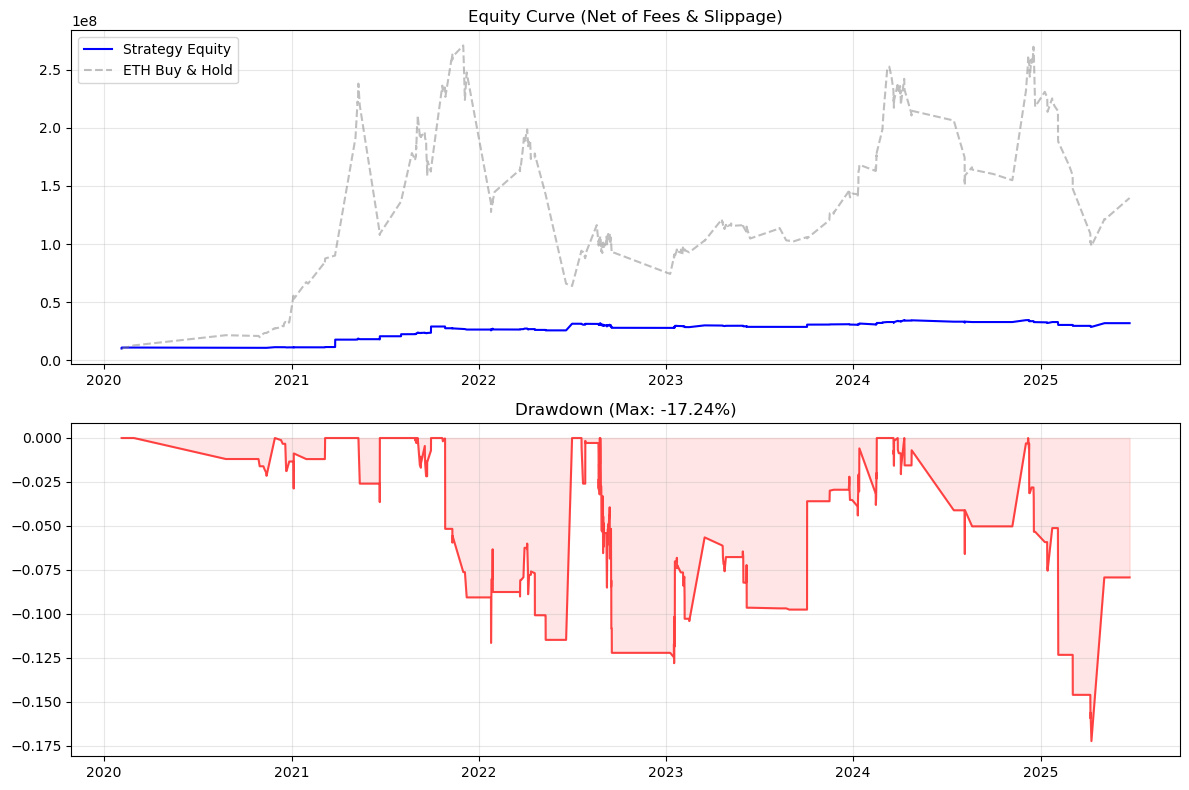

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. 데이터 로드 및 전처리
# =============================================================================
print("Loading Data & Preparing Backtest...")

try:
    # 파일 로드 (파일명이 정확한지 확인해주세요)
    signals = pd.read_csv("trade_signals_strategic.csv")
    signals["timestamp"] = pd.to_datetime(signals["timestamp"])

    market_data = pd.read_csv("eth_4hour_master.csv")
    if "date" in market_data.columns: market_data = market_data.rename(columns={"date": "timestamp"})
    market_data["timestamp"] = pd.to_datetime(market_data["timestamp"])

    price_data = pd.read_csv("eth_4hour_raw_price.csv")
    if "date" in price_data.columns: price_data = price_data.rename(columns={"date": "timestamp"})
    price_data["timestamp"] = pd.to_datetime(price_data["timestamp"])

    # 데이터 병합
    full_data = signals.merge(market_data, on="timestamp", how="inner")
    full_data = full_data.merge(price_data, on="timestamp", how="inner")

    # ETH 데이터 필터링 및 정렬
    eth_data = full_data[full_data["asset_id"] == "ETH"].sort_values("timestamp").reset_index(drop=True)
    eth_data = eth_data[eth_data['timestamp'] >= '2020-01-01'].copy()

    # 컬럼 매핑 (안전장치)
    if "ETH_High" in eth_data.columns: eth_data["high_krw"] = eth_data["ETH_High"]
    if "ETH_Low" in eth_data.columns: eth_data["low_krw"] = eth_data["ETH_Low"]
    if "ETH_Close" in eth_data.columns: eth_data["close_krw"] = eth_data["ETH_Close"]
    if "ETH_Open" in eth_data.columns: eth_data["open_krw"] = eth_data["ETH_Open"] # 시가 데이터 필수
    if "ETH_ADX_14" not in eth_data.columns: eth_data["ETH_ADX_14"] = 25 # 결측 시 기본값

    print(f"✅ Data Loaded: {len(eth_data)} rows")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("CSV 파일이 같은 폴더에 있는지 확인해주세요.")
    eth_data = pd.DataFrame()

# =============================================================================
# 2. [Real-World Backtest] 시뮬레이션 엔진
# =============================================================================
if not eth_data.empty:
    # --- 설정 ---
    initial_balance = 10_000_000
    cash = initial_balance
    coin_amount = 0.0
    
    # 수수료 및 슬리피지 설정
    COMMISSION_RATE = 0.0005  # 0.05%
    SLIPPAGE_RATE = 0.0010    # 0.10% (체결 오차)
    
    # 전략 파라미터
    STOP_LOSS = -0.05
    TRAILING_START = 0.04
    TRAILING_CALLBACK = 0.02
    
    # 기록용 리스트
    balance_history = []
    trade_log = []
    
    # 상태 변수
    is_holding = False
    entry_price = 0.0
    max_price_since_entry = 0.0
    entry_ts = None
    
    # 벤치마크 (Buy & Hold) 초기 설정
    first_price = eth_data.iloc[0]["close_krw"]
    bench_coin_amt = initial_balance / first_price

    print("🚀 Starting Simulation with Slippage & Strict Logic...")

    # Loop
    for i in range(len(eth_data) - 1):
        row = eth_data.iloc[i]
        next_row = eth_data.iloc[i+1] # 미래 데이터 (Next Candle)
        
        ts = row["timestamp"]
        current_close = row["close_krw"]
        
        # 1. 자산 평가 (Mark-to-Market)
        current_equity = cash + (coin_amount * current_close)
        bench_val = bench_coin_amt * current_close
        
        # -------------------------------------------------------
        # A. 보유 중일 때 (매도 로직 Check)
        # -------------------------------------------------------
        if is_holding:
            # 다음 봉의 데이터
            next_open = next_row["open_krw"] if "open_krw" in next_row else next_row["close_krw"]
            next_high = next_row["high_krw"]
            next_low = next_row["low_krw"]
            
            sell_signal = False
            sell_reason = ""
            trigger_price = 0.0 # 로직상 발동 가격
            
            # (1) Hard Stop Loss Check (최우선: 캔들 내 저가 도달 여부)
            sl_price = entry_price * (1 + STOP_LOSS)
            
            if next_low <= sl_price:
                sell_signal = True
                sell_reason = "STOP_LOSS"
                trigger_price = sl_price 
            
            # (2) Trailing Stop Check (손절 안 났을 경우)
            if not sell_signal:
                # 고점 갱신 체크
                if next_high > max_price_since_entry:
                    # 이번 캔들에서 고점을 찍었더라도, 그 전에 트레일링 컷이 났는지 확인은 불가능하므로
                    # 보수적으로 '이번 캔들 저가'가 '갱신된 고점 기준 트레일링'에 걸리는지 확인
                    temp_peak = next_high
                    if (temp_peak / entry_price) - 1 >= TRAILING_START:
                        trail_limit = temp_peak * (1 - TRAILING_CALLBACK)
                        if next_low <= trail_limit:
                            sell_signal = True
                            sell_reason = "TRAILING"
                            trigger_price = trail_limit
                    
                    if not sell_signal:
                        max_price_since_entry = temp_peak # 생존 시 고점 갱신 반영

                else:
                    # 고점 갱신 없음. 기존 고점 대비 하락 체크
                    if (max_price_since_entry / entry_price) - 1 >= TRAILING_START:
                        trail_limit = max_price_since_entry * (1 - TRAILING_CALLBACK)
                        if next_low <= trail_limit:
                            sell_signal = True
                            sell_reason = "TRAILING"
                            trigger_price = trail_limit

            # (3) Time Exit (48시간)
            if not sell_signal and (ts - entry_ts).total_seconds() >= 3600 * 48:
                sell_signal = True
                sell_reason = "TIME_LIMIT"
                trigger_price = next_open # 시간 종료 시 다음 봉 시가 청산 가정

            # --- 매도 실행 ---
            if sell_signal:
                # 현실 반영: 슬리피지 적용 (판 가격보다 싸게 팔림)
                # STOP_LOSS나 TRAILING은 트리거 가격에 시장가 매도하므로 슬리피지 발생
                final_sell_price = trigger_price * (1 - SLIPPAGE_RATE)
                
                gross_revenue = coin_amount * final_sell_price
                fee = gross_revenue * COMMISSION_RATE
                
                cash += (gross_revenue - fee)
                trade_ret = (final_sell_price / entry_price) - 1
                
                trade_log.append({
                    "type": "SELL",
                    "reason": sell_reason,
                    "ts": next_row["timestamp"],
                    "price": final_sell_price,
                    "ret": trade_ret,
                    "equity_after": cash
                })
                
                # 상태 초기화
                coin_amount = 0.0
                is_holding = False
                entry_price = 0.0
                max_price_since_entry = 0.0
                
                # 매도한 날의 데이터 기록 후 다음 루프로 (재진입 방지)
                balance_history.append({"ts": ts, "equity": cash, "bench": bench_val})
                continue

        # -------------------------------------------------------
        # B. 미보유 중일 때 (매수 로직 Check)
        # -------------------------------------------------------
        if not is_holding:
            prob = row["prob"]
            adx = row.get("ETH_ADX_14", 25)
            
            bet_ratio = 0.0
            if prob >= 0.8: bet_ratio = 0.99
            elif prob >= 0.70 and adx >= 20: bet_ratio = 0.50
            elif prob >= 0.65 and adx >= 25: bet_ratio = 0.30
            
            if bet_ratio > 0:
                invest_amount = cash * bet_ratio
                
                # 최소 주문 금액 (예: 5000원)
                if invest_amount > 5000:
                    # 현실 반영: 다음 봉 시가(Open)에 진입
                    raw_entry_price = next_row["open_krw"] if "open_krw" in next_row else next_row["close_krw"]
                    
                    # 슬리피지 적용 (본 가격보다 비싸게 사짐)
                    real_entry_price = raw_entry_price * (1 + SLIPPAGE_RATE)
                    
                    # 수수료 차감 후 코인 개수 계산
                    fee = invest_amount * COMMISSION_RATE
                    real_invest = invest_amount - fee
                    bought_coins = real_invest / real_entry_price
                    
                    # 상태 업데이트
                    cash -= invest_amount
                    coin_amount += bought_coins
                    
                    is_holding = True
                    entry_price = real_entry_price
                    max_price_since_entry = real_entry_price
                    entry_ts = ts
                    
                    trade_log.append({
                        "type": "BUY",
                        "ts": next_row["timestamp"],
                        "price": real_entry_price,
                        "prob": prob,
                        "size_ratio": bet_ratio
                    })

        # 일별 기록 (Hold 중이면 평가금액, 아니면 현금)
        balance_history.append({"ts": ts, "equity": current_equity, "bench": bench_val})

    # =============================================================================
    # 3. 결과 분석 및 시각화
    # =============================================================================
    if balance_history:
        res_df = pd.DataFrame(balance_history).set_index("ts")
        tr_df = pd.DataFrame(trade_log)
        
        # 수익률 계산
        final_equity = res_df.iloc[-1]["equity"]
        total_return = (final_equity / initial_balance) - 1
        bench_return = (res_df.iloc[-1]["bench"] / initial_balance) - 1
        
        # MDD 계산
        res_df["peak"] = res_df["equity"].cummax()
        res_df["dd"] = (res_df["equity"] - res_df["peak"]) / res_df["peak"]
        mdd = res_df["dd"].min()
        
        print("\n" + "="*50)
        print(f" [Final Strategy Report]")
        print(f" Final Equity    : {final_equity:,.0f} KRW")
        print(f" Strategy Return : {total_return*100:.2f}%")
        print(f" Benchmark Return: {bench_return*100:.2f}%")
        print(f" Max Drawdown    : {mdd*100:.2f}%")
        
        if not tr_df.empty:
            sells = tr_df[tr_df["type"] == "SELL"]
            win_cnt = len(sells[sells["ret"] > 0])
            total_sells = len(sells)
            win_rate = win_cnt / total_sells if total_sells > 0 else 0
            
            print(f" Total Trades    : {len(tr_df[tr_df['type']=='BUY'])}")
            print(f" Win Rate        : {win_rate*100:.2f}% ({win_cnt}/{total_sells})")
            print(f" Avg Profit      : {sells[sells['ret']>0]['ret'].mean()*100:.2f}%")
            print(f" Avg Loss        : {sells[sells['ret']<=0]['ret'].mean()*100:.2f}%")
        print("="*50)
        
        # 그래프 그리기
        plt.figure(figsize=(12, 8))
        
        # 1. 자산 곡선
        plt.subplot(2, 1, 1)
        plt.plot(res_df.index, res_df["equity"], label="Strategy Equity", color="blue")
        plt.plot(res_df.index, res_df["bench"], label="ETH Buy & Hold", color="gray", alpha=0.5, linestyle="--")
        plt.title("Equity Curve (Net of Fees & Slippage)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Drawdown
        plt.subplot(2, 1, 2)
        plt.plot(res_df.index, res_df["dd"], color="red", alpha=0.7, label="Drawdown")
        plt.fill_between(res_df.index, res_df["dd"], 0, color="red", alpha=0.1)
        plt.title(f"Drawdown (Max: {mdd*100:.2f}%)")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    else:
        print("⚠️ No balance history generated.")

else:
    print("⚠️ No data available to run simulation.")

In [123]:
df=pd.read_csv("trade_signals_strategic.csv")

print(df.head(1))

cond=df['asset_id']=="ETH"
df=df[cond]
cond1=(df['is_breakout']==1)
print(df)

             timestamp asset_id  close_krw      prob  is_breakout
0  2018-11-19 17:00:00      ADA       62.1  0.716534            0
                timestamp asset_id  close_krw      prob  is_breakout
3     2018-11-20 13:00:00      ETH   157150.0  0.752701            1
4     2018-11-20 17:00:00      ETH   152250.0  0.676424            1
8     2018-11-23 17:00:00      ETH   142100.0  0.768040            0
11    2018-11-23 21:00:00      ETH   140550.0  0.689531            0
19    2018-11-25 09:00:00      ETH   121350.0  0.742017            1
...                   ...      ...        ...       ...          ...
4297  2025-05-04 09:00:00      ETH  2627000.0  0.651255            0
4298  2025-05-04 13:00:00      ETH  2639000.0  0.697084            0
4301  2025-05-05 01:00:00      ETH  2625000.0  0.712159            0
4315  2025-06-22 21:00:00      ETH  3032000.0  0.656293            1
4338  2025-10-02 05:00:00      ETH  6176000.0  0.831267            1

[598 rows x 5 columns]
